In [ ]:
# import the necessary packages
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [ ]:
# get file names of frames
col_frames = os.listdir('/content/drive/MyDrive/Prerna_CVT_Project/frames/')
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# load frames
col_images=[]
for i in tqdm_notebook(col_frames):
    img = cv2.imread('/content/drive/MyDrive/Prerna_CVT_Project/frames/'+i)
    col_images.append(img)

<ipython-input-60-aca353e5a9a9>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(col_frames):


  0%|          | 0/1108 [00:00<?, ?it/s]

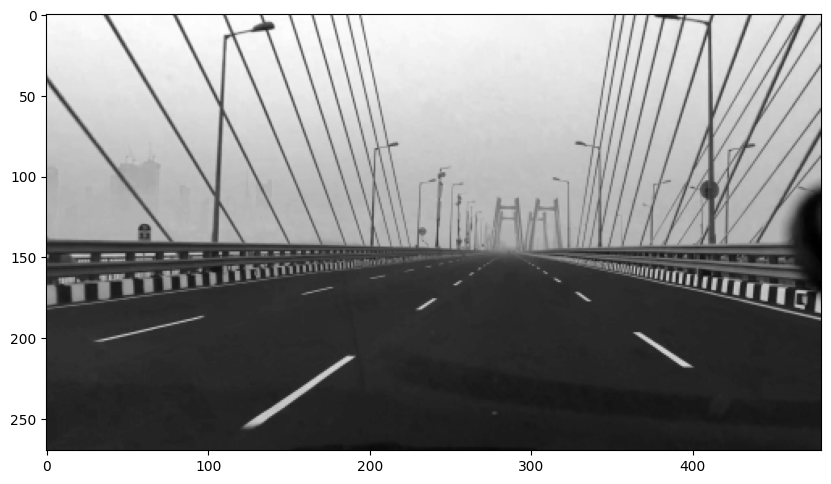

In [ ]:
# specify frame index
idx = 10

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(col_images[idx][:,:,0], cmap= "gray")
plt.show()

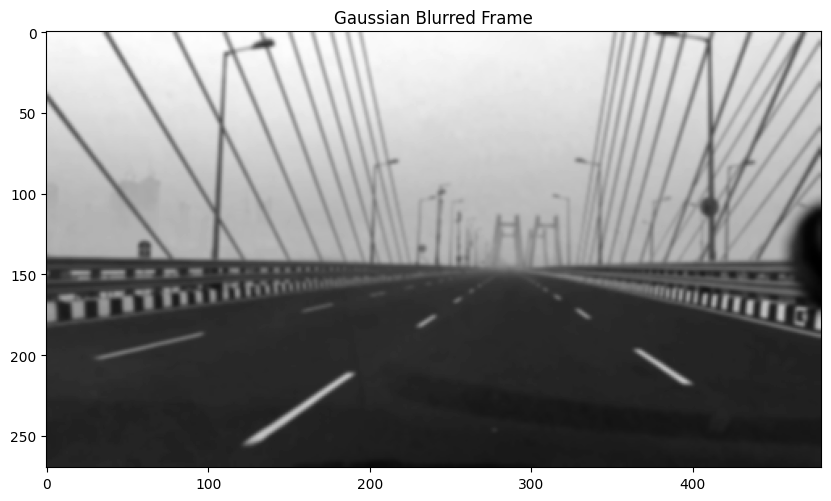

In [ ]:
frame = col_images[idx][:,:,0]  # Assuming it's already grayscale

# Apply Gaussian blur with a kernel size of (5, 5) and a standard deviation of 0
blurred_frame = cv2.GaussianBlur(frame, (5, 5), 0)

# Plot only the blurred frame
plt.figure(figsize=(10, 10))
plt.title("Gaussian Blurred Frame")
plt.imshow(blurred_frame, cmap="gray")
plt.show()

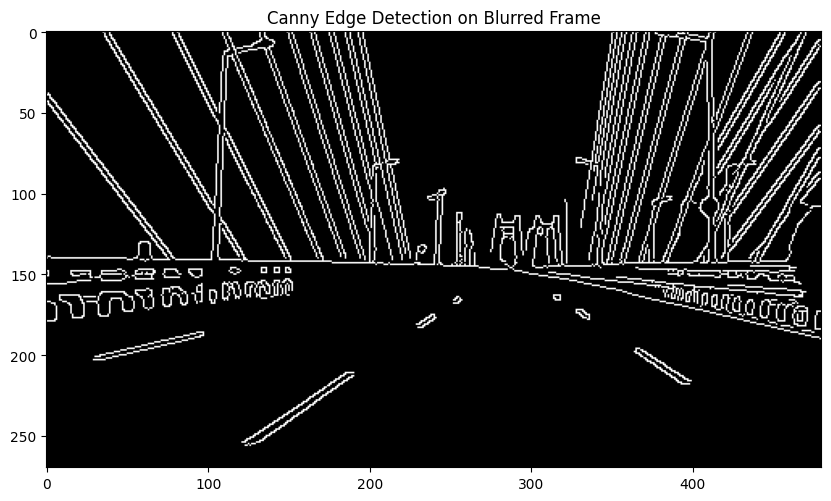

In [ ]:
# Apply Canny edge detection on the blurred frame
edges = cv2.Canny(blurred_frame, threshold1=50, threshold2=150)

# Plot only the edges detected
plt.figure(figsize=(10, 10))
plt.title("Canny Edge Detection on Blurred Frame")
plt.imshow(edges, cmap="gray")
plt.show()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
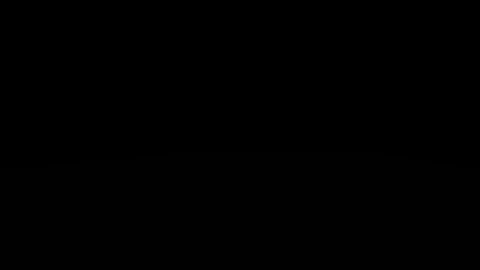

In [ ]:
# Create a zero array for the mask
stencil = np.zeros_like(col_images[idx][:,:,0])

# Define the coordinates of the polygon for masking the region of interest
#polygon = np.array([[0, 270], [100, 160], [400, 160], [480, 270], [0 ,180], [480, 180]])

polygon = np.array([[0, 270], [0 ,170], [220, 150], [360, 150],[480, 170], [480, 270]])


# Fill the polygon with ones (to create a mask in that region)
cv2.fillConvexPoly(stencil, polygon, 1)

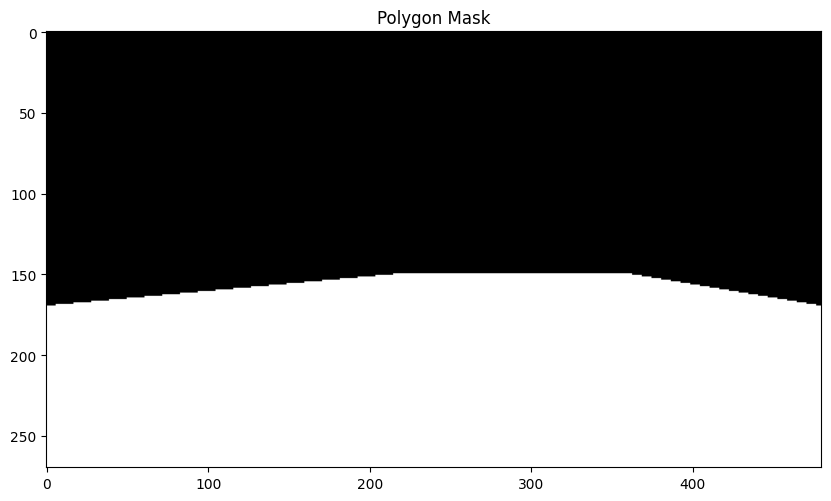

In [ ]:
# Plot the polygon mask
plt.figure(figsize=(10, 10))
plt.imshow(stencil, cmap="gray")
plt.title("Polygon Mask")
plt.show()

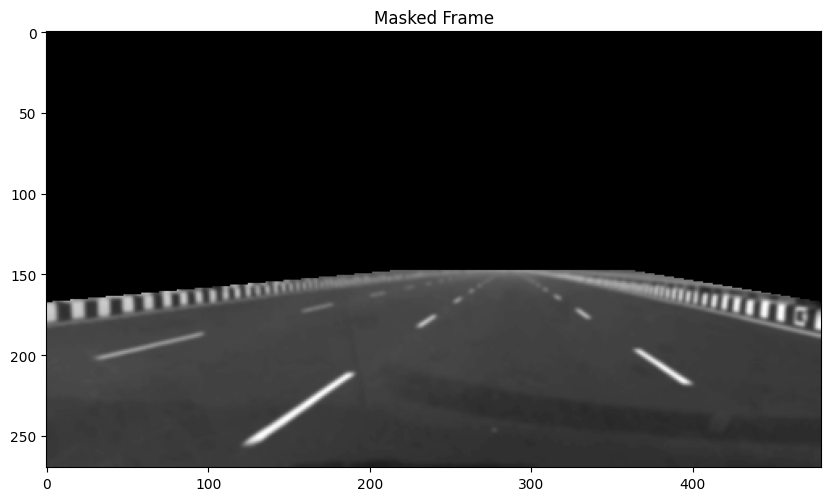

In [ ]:
# Dilate the mask to blur out the polygon border (optional)
kernel = np.ones((5, 5), np.uint8)
dilated_stencil = cv2.dilate(stencil, kernel, iterations=1)

# Apply the mask on the blurred image
masked_blurred_frame = cv2.bitwise_and(blurred_frame, blurred_frame, mask=dilated_stencil)

# Plot the masked frame
plt.figure(figsize=(10, 10))
plt.imshow(masked_blurred_frame, cmap="gray")
plt.title("Masked Frame")
plt.show()

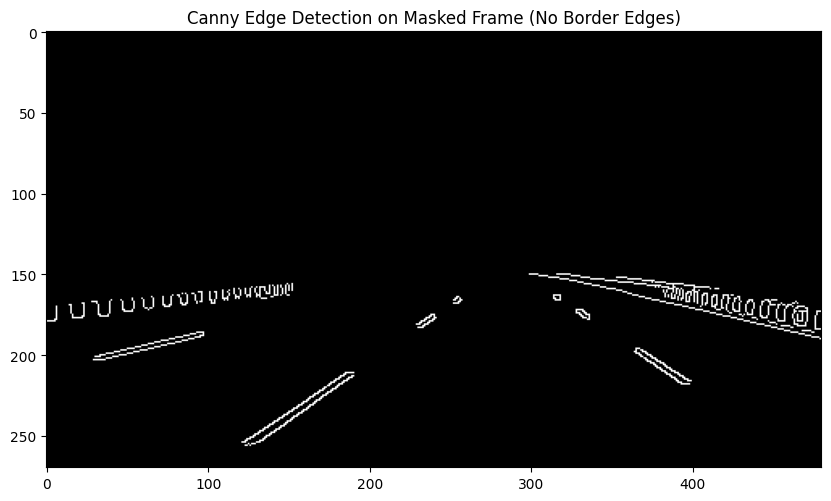

In [ ]:
# Apply Canny edge detection on the masked, blurred image
edges = cv2.Canny(masked_blurred_frame, threshold1=50, threshold2=150)

# Reapply the mask to remove border edges that may have been detected
edges = cv2.bitwise_and(edges, edges, mask=stencil)

# Display the results
plt.figure(figsize=(10, 10))
plt.title("Canny Edge Detection on Masked Frame (No Border Edges)")
plt.imshow(edges, cmap="gray")
plt.show()

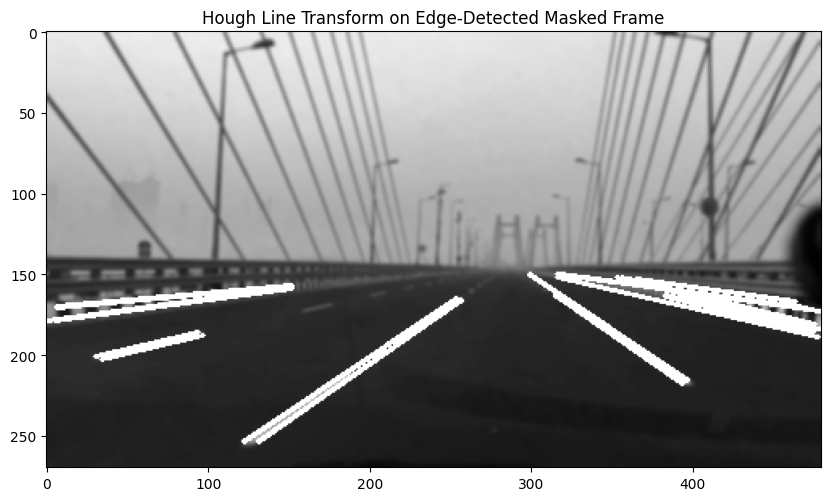

In [ ]:
# Apply Hough Line Transform on the edge-detected image
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=30, minLineLength=50, maxLineGap=200)

# Create a copy of the original (blurred) image to draw the lines
line_image = np.copy(blurred_frame)

# Draw the detected lines on the image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)

# Display the image with Hough lines
plt.figure(figsize=(10, 10))
plt.title("Hough Line Transform on Edge-Detected Masked Frame")
plt.imshow(line_image, cmap="gray")
plt.show()

## Pipeline

In [ ]:
# Define polygon for the region of interest
polygon = np.array([[0, 270], [0 ,170], [220, 150], [360, 150],[480, 170], [480, 270]])

# Path to save results
save_path = '/content/drive/MyDrive/Prerna_CVT_Project/detected_exp_3/'
cnt = 0

for img in tqdm_notebook(col_images):
    # Step 1: Apply Gaussian blur
    blurred_frame = cv2.GaussianBlur(img[:, :, 0], (5, 5), 0)

    # Step 2: Create and apply mask
    stencil = np.zeros_like(blurred_frame)
    cv2.fillConvexPoly(stencil, polygon, 1)
    kernel = np.ones((5, 5), np.uint8)
    dilated_stencil = cv2.dilate(stencil, kernel, iterations=1)
    masked_blurred_frame = cv2.bitwise_and(blurred_frame, blurred_frame, mask=dilated_stencil)

    # Step 3: Apply Canny edge detection with adjusted thresholds
    edges = cv2.Canny(masked_blurred_frame, threshold1=100, threshold2=200)

    # Step 4: Apply mask to edges to remove borders
    edges = cv2.bitwise_and(edges, edges, mask=stencil)

    # Step 5: Apply Hough Line Transform with adjusted parameters
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=30, minLineLength=30, maxLineGap=100)

    # Step 6: Draw detected lines on a copy of the blurred frame for better visibility
    line_image = img.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), thickness=3)  # Drawing in color (255, 0, 0)

    # Save the result
    result_path = f"{save_path}{cnt}.png"
    cv2.imwrite(result_path, line_image)

    cnt += 1

<ipython-input-74-3af6522e399a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm_notebook(col_images):


  0%|          | 0/1108 [00:00<?, ?it/s]

In [ ]:
# input frames path
pathIn= '/content/drive/MyDrive/Prerna_CVT_Project/detected_exp_3/'

# output path to save the video
pathOut = '/content/drive/MyDrive/Prerna_CVT_Project/roads_v2_exp_3.mp4'

# specify frames per second
fps = 30.0

In [ ]:
from os.path import isfile, join

# get file names of the frames
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
files.sort(key=lambda f: int(re.sub('\D', '', f)))

In [ ]:
frame_list = []

for i in tqdm_notebook(range(len(files))):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)

    #inserting the frames into an image array
    frame_list.append(img)

<ipython-input-77-1d2ff98c4d85>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(files))):


  0%|          | 0/1108 [00:00<?, ?it/s]

In [ ]:
# write the video
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_list)):
    # writing to a image array
    out.write(frame_list[i])

out.release()